In [1]:
# autoreload magic to ensure up-to-date code
%load_ext autoreload
%autoreload 2

In [ ]:
from tqdm import tqdm
from typing import Callable

import numpy as np

# torch stuff
import torch
import torch.nn as nn

# plotting
import matplotlib.pyplot as plt

### Utility functions

In [4]:
def flip_xaxis(ax):
    ax.set_xlim(ax.get_xlim()[::-1])


def remove_ticks(ax: plt.Axes):
    ax.set_xticks([], [])
    ax.set_yticks([], [])


def remove_spines(ax: plt.Axes):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

In [5]:
def plot_distribution_on_ax(ax, ps, s=1):
    ax.scatter(ps, torch.zeros_like(ps), s=s)
    ax.set_aspect("equal")
    # ax.set_xlim(-9, 9)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("x")
    ax.set_yticks([], [])

In [6]:
def source_dist(n_samples: int) -> torch.Tensor:
    return torch.randn(n_samples, 1)


def target_dist(n_samples: int) -> torch.Tensor:
    return torch.concatenate(
        [
            torch.randn(n_samples // 2, 1) * 0.3 - 1.5,
            torch.randn(n_samples // 2, 1) * 0.2 + 1.5,
        ]
    )

In [87]:
def sample_time(B):
    return torch.rand(B, 1)

In [20]:
def get_xt_dist(
    x0_dist,
    x1_dist,
    t_dist,
    fm,
    bins=np.linspace(-7, 7, 200),
    rng=np.random.default_rng(42),
):
    xt_dist = []
    for t in tqdm(t_dist):
        x0_dist_shuffled = rng.permutation(x0_dist)
        x1_dist_shuffled = rng.permutation(x1_dist)
        xt_dist.append(
            np.histogram(
                fm.sample_xt(
                    x0_dist_shuffled.reshape(1, -1), x1_dist_shuffled.reshape(-1, 1), t
                ),
                bins=bins,
                density=True,
            )[0]
        )
    return np.array(xt_dist)


def get_ut_dist(
    x0_dist,
    x1_dist,
    t_dist,
    fm,
    bins=np.linspace(-7, 7, 200),
    rng=np.random.default_rng(42),
):
    ut_dist = []
    for t in tqdm(t_dist):
        x0_dist_shuffled = rng.permutation(x0_dist)
        x1_dist_shuffled = rng.permutation(x1_dist)
        ut_dist.append(
            np.histogram(
                fm.sample_ut(
                    x0_dist_shuffled.reshape(1, -1), x1_dist_shuffled.reshape(-1, 1), t
                ),
                bins=bins,
                density=False,
            )[0]
            / len(x0_dist)
            / len(x1_dist)
        )
    return np.array(ut_dist)

In [83]:
def plot_cfm_path(fm, xt_dist, t_dist):
    fig, ax = plt.subplot_mosaic(
        [["x0", "xt", "x1"]], figsize=(10, 5), width_ratios=[1, 4, 1], dpi=200
    )
    n_samples_plot = int(2e6)
    ax["x0"].hist(
        source_dist(n_samples_plot), bins=500, density=True, orientation="horizontal"
    )
    flip_xaxis(ax["x0"])
    ax["x1"].hist(
        target_dist(n_samples_plot), bins=500, density=True, orientation="horizontal"
    )
    ax["xt"].imshow(xt_dist.T, origin="lower", aspect="auto", extent=[0, 1, -3, 3])
    for i in range(5):
        x_origin = source_dist(1)[0]
        x_target = target_dist(2)[i % 2]
        ax["xt"].plot(
            t_dist,
            fm.sample_xt(x_origin, x_target, t_dist),
            color="red",
            lw=1,
        )
    for value in ax.values():
        value.set_ylim(-3, 3)
    ax["xt"].set_yticks([], [])
    ax["x1"].yaxis.tick_right()
    remove_ticks(ax["x0"])
    remove_ticks(ax["x1"])
    remove_spines(ax["x0"])
    remove_spines(ax["x1"])
    fig.subplots_adjust(wspace=0.025)
    plt.show()

In [131]:
def plot_sampling(ax, ds, ts):
    ds = ds.cpu()
    ts = ts.cpu()
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    batch_size = ds.shape[1]
    for b in range(batch_size):
        ax.plot(ts[:, b], ds[:, b, 0], linewidth=1, color=(0.25, 0.25, 0.75, 0.25))

## Conditional Flow Matching

In [31]:
class ConditionalFlowMatching:
    def __init__(
        self,
        alpha_t: Callable,
        sigma_t: Callable,
        alpha_dot_t: Callable,
        sigma_dot_t: Callable,
    ):
        self.alpha_t = alpha_t
        self.sigma_t = sigma_t
        self.alpha_dot_t = alpha_dot_t
        self.sigma_dot_t = sigma_dot_t

    def sample_xt(
        self,
        x0: torch.Tensor | float,
        x1: torch.Tensor | float,
        t: torch.Tensor | float,
    ) -> torch.Tensor:
        return self.alpha_t(t) * x1 + self.sigma_t(t) * x0

    def sample_ut(
        self,
        x0: torch.Tensor | float,
        x1: torch.Tensor | float,
        t: torch.Tensor | float,
    ) -> torch.Tensor:
        return self.alpha_dot_t(t) * x1 + self.sigma_dot_t(t) * x0

### Conditional probability path choice

$$
    x_t = \alpha_t x_0 + \sigma_t x_1
$$

- Linear path:
    - $\alpha_t = t$
    - $\sigma_t = 1 - t$
- Cosine path:
    - $\alpha_t = \sin(\pi t / 2)$
    - $\sigma_t = \cos(\pi t / 2)$

In [32]:
linear_fm = ConditionalFlowMatching(
    alpha_t=lambda t: t,
    sigma_t=lambda t: 1 - t,
    alpha_dot_t=lambda t: 1,
    sigma_dot_t=lambda t: -1,
)
cosine_fm = ConditionalFlowMatching(
    alpha_t=lambda t: torch.sin(t * torch.pi / 2),
    sigma_t=lambda t: torch.cos(t * torch.pi / 2),
    alpha_dot_t=lambda t: torch.cos(t * torch.pi / 2),
    sigma_dot_t=lambda t: -torch.sin(t * torch.pi / 2),
)

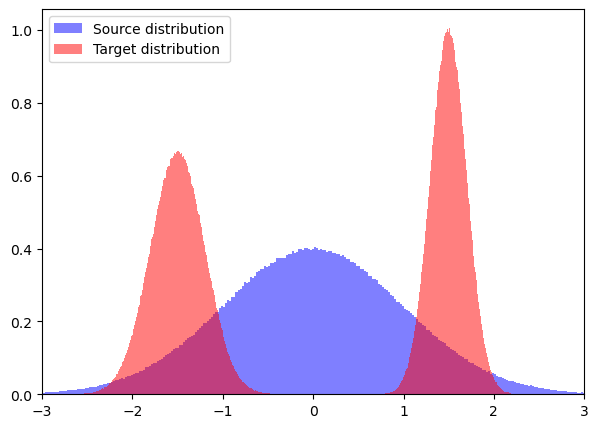

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(
    source_dist(int(2e6)).flatten(),
    bins=500,
    density=True,
    alpha=0.5,
    color="blue",
    label="Source distribution",
)
ax.hist(
    target_dist(int(2e6)).flatten(),
    bins=500,
    density=True,
    alpha=0.5,
    color="red",
    label="Target distribution",
)
ax.legend()
ax.set_xlim(-3, 3)
plt.show()

In [66]:
n_samples = int(1e3)
x0_dist = source_dist(n_samples)[..., 0]
x1_dist = target_dist(n_samples)[..., 0]

In [72]:
t_dist = torch.linspace(0, 1, 50)

xt_dist_linear = get_xt_dist(
    x0_dist.to(torch.float16),
    x1_dist.to(torch.float16),
    t_dist.to(torch.float16),
    linear_fm,
    bins=torch.linspace(-3, 3, 500),
)
xt_dist_cosine = get_xt_dist(
    x0_dist.to(torch.float16),
    x1_dist.to(torch.float16),
    t_dist.to(torch.float16),
    cosine_fm,
    bins=torch.linspace(-3, 3, 500),
)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_3828738/2527670887.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return self.alpha_t(t) * x1 + self.sigma_t(t) * x0
100%|██████████| 50/50 [00:03<00:00, 13.09it/s]


In [75]:
t_dist_plot = torch.linspace(0, 1, 100)

#### Linear path: $x_t$ trajectories

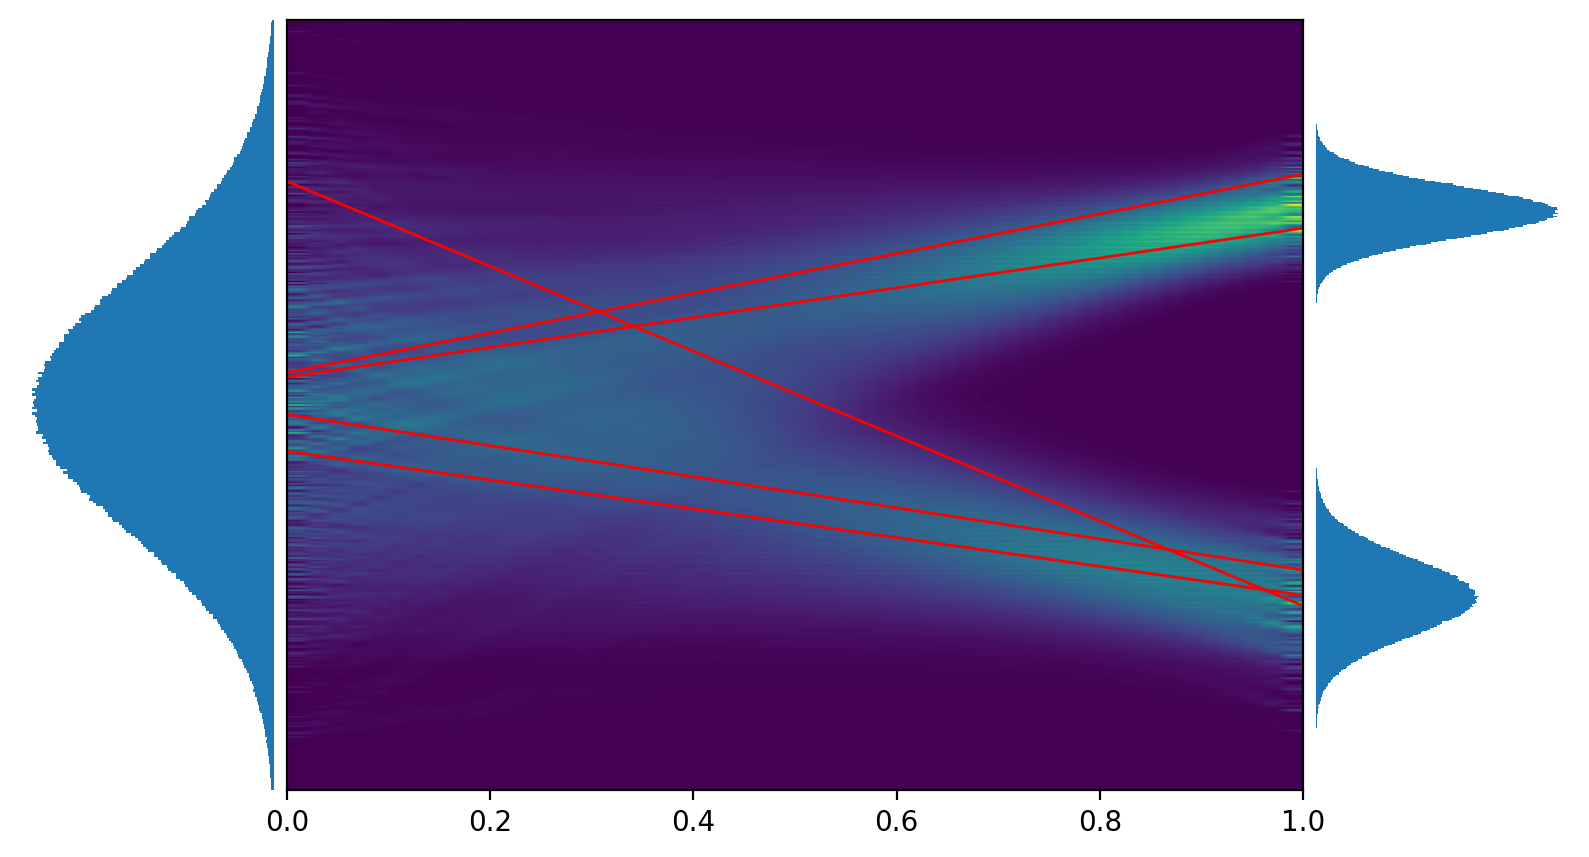

In [84]:
plot_cfm_path(
    linear_fm,
    xt_dist_linear,
    t_dist_plot,
)

#### Cosine path: $x_t$ trajectories

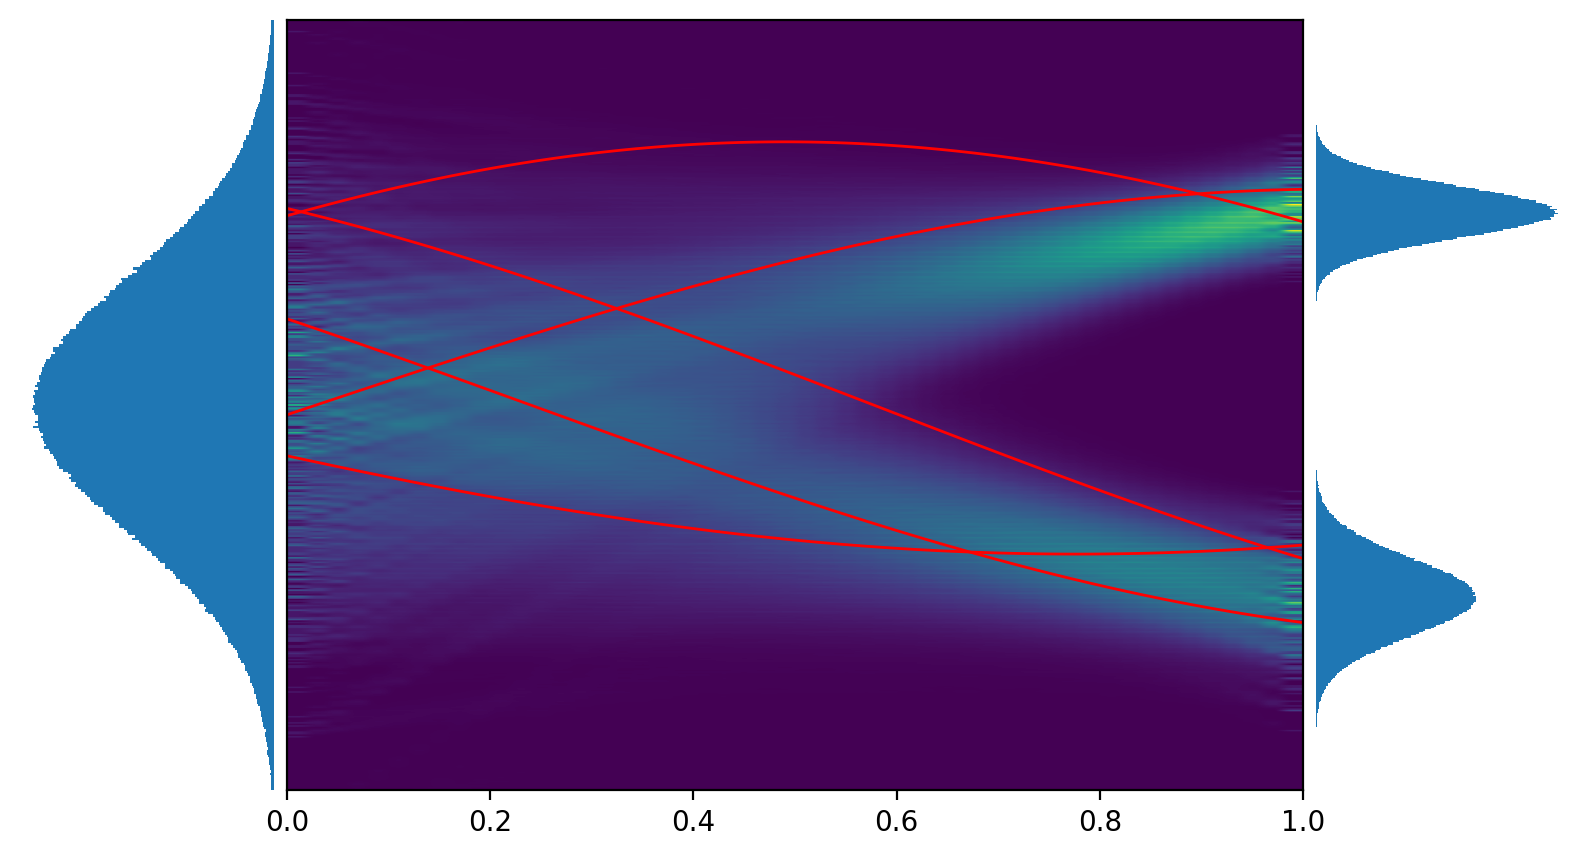

In [86]:
plot_cfm_path(
    cosine_fm,
    xt_dist_linear,
    t_dist_plot,
)

### Learning the Flow

In [88]:
class Model(nn.Module):
    def __init__(self, dim, n_layers=6):
        super().__init__()
        self.dim = dim
        self.init_net = nn.Sequential(
            nn.Linear(2, dim),
            nn.GELU(approximate="tanh"),
        )
        self.layers = []
        for i in range(n_layers):
            self.layers.extend(
                [
                    nn.Linear(dim, dim),
                    nn.GELU(approximate="tanh"),
                ]
            )
        self.layers = nn.Sequential(*self.layers)
        self.final_layer = nn.Linear(dim, 1)

    def forward(self, x, t):
        embd = self.init_net(torch.cat((x, t), -1))
        embd = self.layers(embd)
        return self.final_layer(embd)

In [89]:
def train_batch(model, device, optimizer, dist0, dist1, batch_size, fm):
    model.train()

    # Sample from the source distribution
    d0 = dist0(batch_size)
    # Sample from the target distribution
    d1 = dist1(batch_size)
    # Sample time uniformly from [0, 1]
    time = sample_time(batch_size)

    model.to(device)
    d0 = d0.to(device)
    d1 = d1.to(device)
    time = time.to(device)

    optimizer.zero_grad()

    # Sample xt and ut from the corresponding conditional probabilty path
    xt = fm.sample_xt(d0, d1, time)
    ut = fm.sample_ut(d0, d1, time)
    flow = model(xt, time)
    # Compute the loss as the MSE between the model output and the ut
    batch_loss = nn.MSELoss()(flow, ut)

    batch_loss.backward()
    optimizer.step()

    return batch_loss.item()

In [123]:
def sample_model(model, device, dist0, batch_size=512, steps=1024, x0=None):
    model.eval()

    dt = 1.0 / steps

    if x0 is not None:
        x = x0
        batch_size = x0.shape[0]
    else:
        # Sample from the source distribution
        x = dist0(batch_size)
    t = torch.linspace(0, 1, steps + 1).view(-1, 1).repeat(1, batch_size)
    xs = torch.zeros(steps + 1, batch_size, 1)

    model.to(device)
    x = x.to(device)

    xs[0] = x.cpu()

    with torch.no_grad():
        for step in range(steps):
            # Do a single step of the Euler method
            x = x + dt * model(x, t[step].view(-1, 1).to(device))
            # Save the current state
            xs[step + 1] = x.cpu()
    return xs, t

In [93]:
model_linear = Model(128)
model_cosine = Model(128)
optimizer_linear = torch.optim.AdamW(model_linear.parameters(), lr=0.005)
optimizer_cosine = torch.optim.AdamW(model_cosine.parameters(), lr=0.005)

In [94]:
batch_size = 2048
batches = 4096 * 8
for b in range(batches):
    batch_loss = train_batch(
        model_linear,
        "cuda",
        optimizer_linear,
        source_dist,
        target_dist,
        batch_size,
        linear_fm,
    )
    print(f"{b + 1}/{batches}: {batch_loss:.3f}", end="\r")

In [133]:
batch_size = 2048
batches = 4096 * 8
for b in range(batches):
    batch_loss = train_batch(
        model_cosine,
        "cuda",
        optimizer_cosine,
        source_dist,
        target_dist,
        batch_size,
        cosine_fm,
    )
    print(f"{b + 1}/{batches}: {batch_loss:.3f}", end="\r")

#### Linear path: sampling trajectories

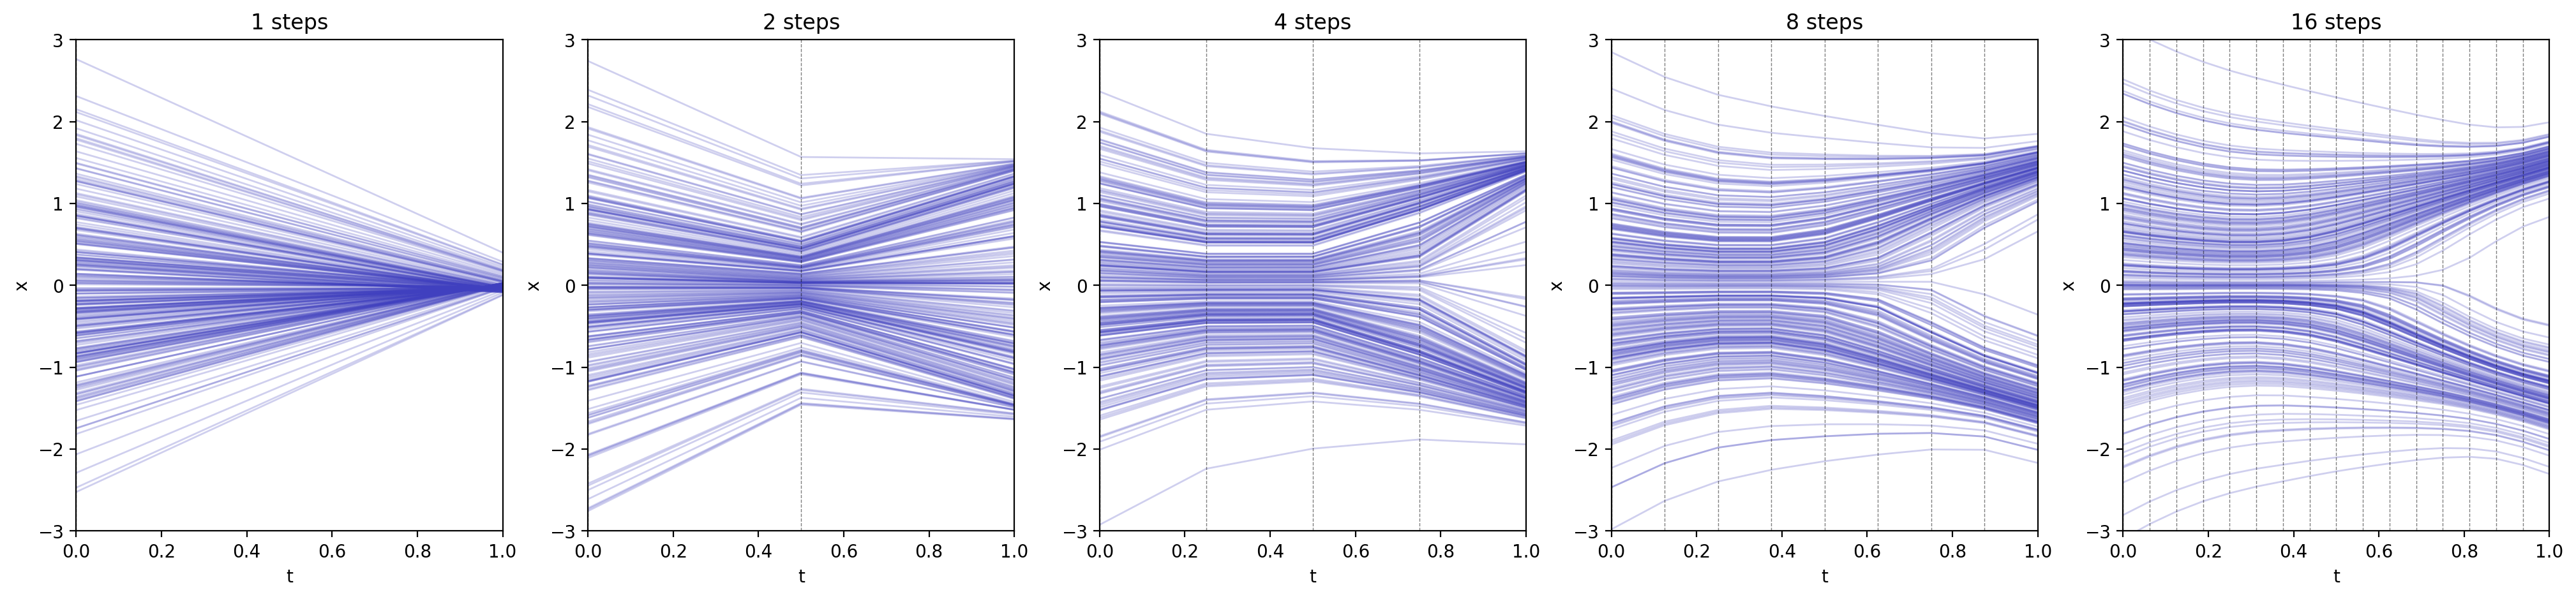

In [132]:
n = 5
fig, ax = plt.subplots(ncols=n, nrows=1, figsize=(5 * n, 5), dpi=200)
for i in range(n):
    N = 2**i
    ds, ts = sample_model(model_linear, "cuda", source_dist, batch_size=256, steps=N)
    plot_sampling(ax[i], ds, ts)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(-3, 3)
    for j in range(N):
        ax[i].plot(
            [j / N, j / N],
            [-3, 3],
            color=(0, 0, 0, 0.5),
            linewidth=0.5,
            linestyle="dashed",
        )
    ax[i].set_title(f"{N} steps")

#### Cosine path: sampling trajectories

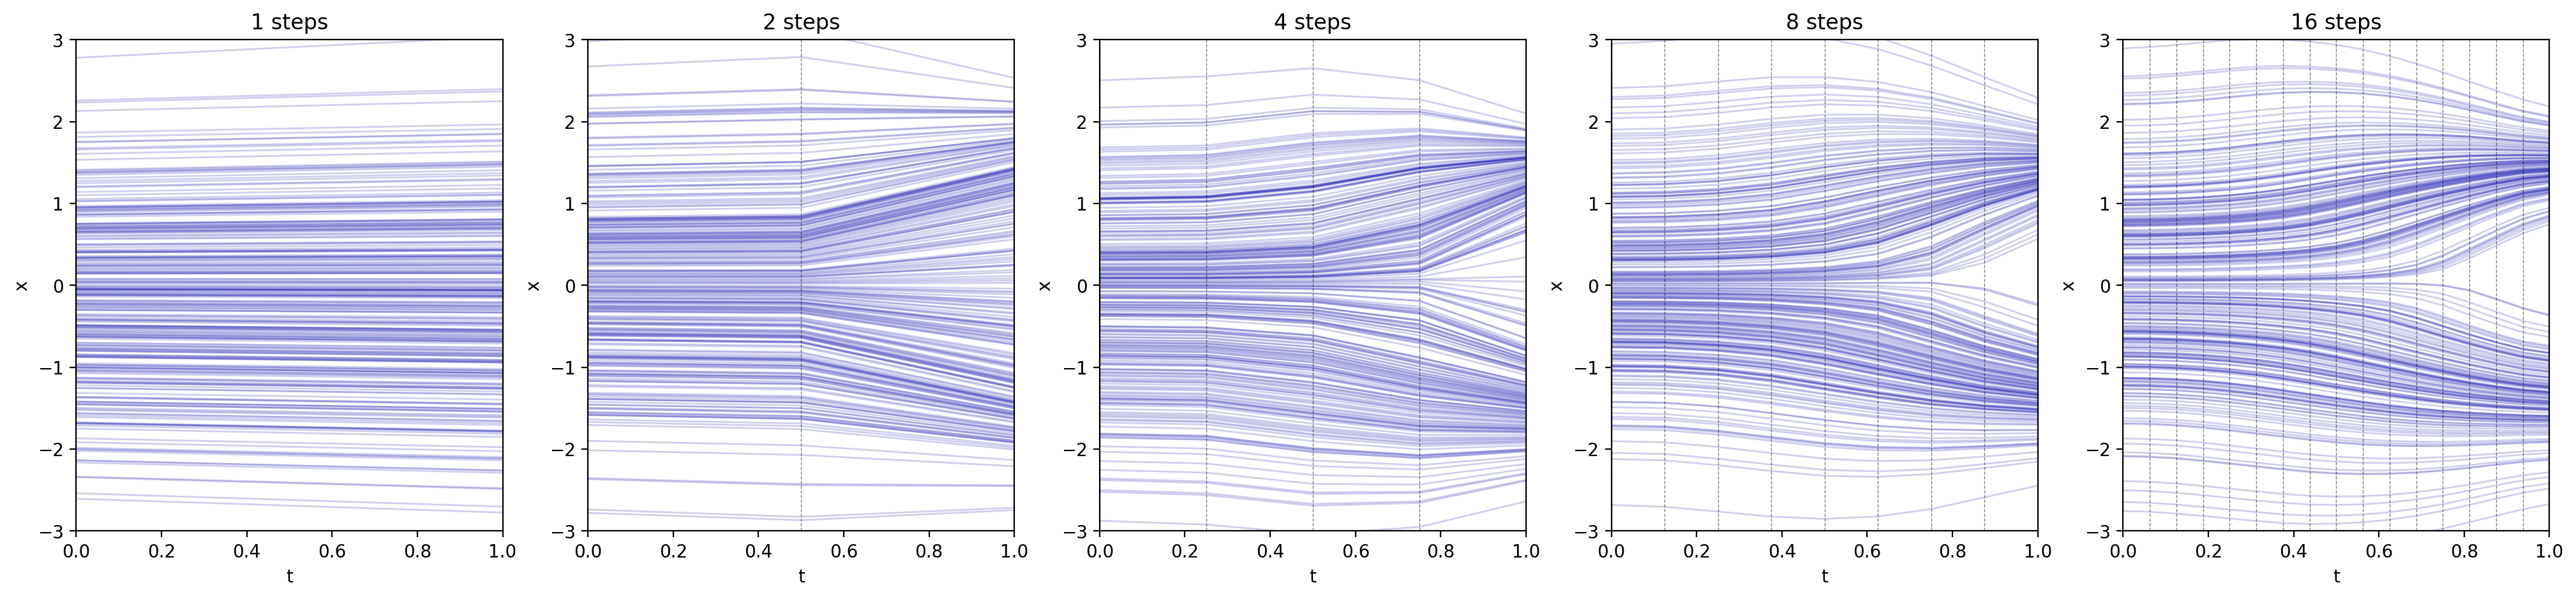

In [134]:
n = 5
fig, ax = plt.subplots(ncols=n, nrows=1, figsize=(5 * n, 5), dpi=200)
for i in range(n):
    N = 2**i
    ds_cosine, ts_cosine = sample_model(
        model_cosine, "cuda", source_dist, batch_size=256, steps=N
    )
    plot_sampling(ax[i], ds_cosine, ts_cosine)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(-3, 3)
    for j in range(N):
        ax[i].plot(
            [j / N, j / N],
            [-3, 3],
            color=(0, 0, 0, 0.5),
            linewidth=0.5,
            linestyle="dashed",
        )
    ax[i].set_title(f"{N} steps")

In [142]:
ds_cosine, _ = sample_model(
    model_cosine, "cuda", source_dist, batch_size=4096 * 4, steps=64
)
ds_linear, _ = sample_model(
    model_linear, "cuda", source_dist, batch_size=4096 * 4, steps=64
)

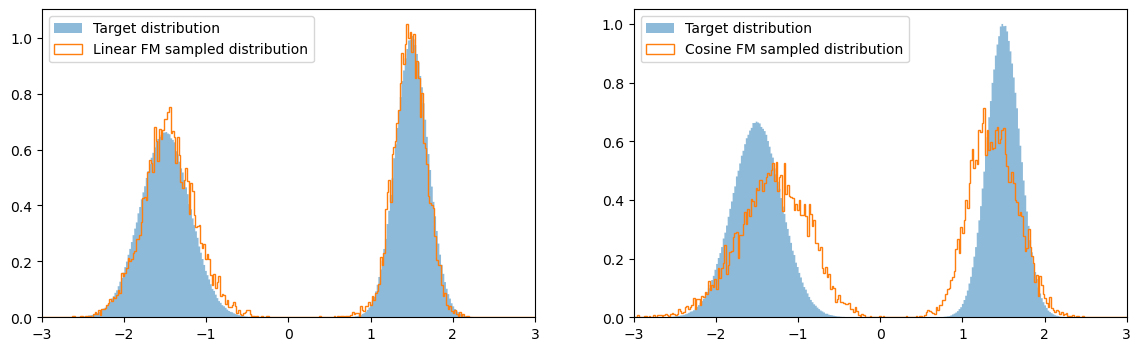

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
bins = np.linspace(-3, 3, 300)
labels = ["Linear FM", "Cosine FM"]
for i, ds_ in enumerate([ds_linear, ds_cosine]):
    ax[i].hist(
        target_dist(int(2e6)).flatten(),
        bins=bins,
        density=True,
        alpha=0.5,
        histtype="stepfilled",
        label="Target distribution",
    )
    ax[i].hist(
        ds_[-1].flatten(),
        bins=bins,
        density=True,
        histtype="step",
        label=labels[i] + " sampled distribution",
    )
    ax[i].set_xlim(-3, 3)
    ax[i].legend()
plt.show()